# Toy DDPM

In [1]:
#@markdown Install dependencies.

!pip -q install einops datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 713.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00


In [46]:
#@markdown Implement the noise schedule and sampler.

from dataclasses import dataclass
import math

import torch
import torch.nn as nn


def explicit_broadcast(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """Explicitly broadcast x to y."""

    axes = (1,)*max(len(y.shape) - len(x.shape), 0)

    return x.view(x.shape + axes)


class DDPMSchedule:

    def __init__(self, start: float, end: float, steps: int) -> None:

        self.start = start
        self.end = end
        self.steps = steps
        self.beta = torch.linspace(start, end, steps)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def forward(
        self,
        x: torch.Tensor,
        noise: torch.Tensor,
        step: torch.Tensor,
    ) -> torch.Tensor:
        """Sample from the forward process."""

        alpha_bar = self.alpha_bar.to(x.device)[step]
        a = explicit_broadcast(torch.sqrt(alpha_bar), x)
        b = explicit_broadcast(torch.sqrt(1 - alpha_bar), x)

        return a*x + b*noise


@torch.no_grad()
def sample_ddpm(
    model: nn.Module,
    schedule: DDPMSchedule,
    x: torch.Tensor,
) -> torch.Tensor:
    """Sample from the model."""

    for step in reversed(range(schedule.steps)):

        z = torch.randn_like(x).to(x.device) if (step > 0) else 0.

        alpha = schedule.alpha[step].item()
        alpha_bar = schedule.alpha_bar[step].item()
        beta = 1 - alpha
        noise = model(x, torch.full((x.size(0),), step).to(x.device))

        x = 1/math.sqrt(alpha) * (x - beta/math.sqrt(1-alpha_bar)*noise) + math.sqrt(beta)*z

    return x

In [13]:
#@markdown Implement the trainer.

from dataclasses import dataclass
import gc

import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm


@dataclass
class Trainer:

    effective_batch_size: int
    sample_steps: int
    checkpoint_steps: int

    def train(
        self,
        model: nn.Module,
        schedule: DDPMSchedule,
        optimizer: torch.optim.Optimizer,
        dataloader: torch.utils.data.DataLoader,
        x_column: str,
        steps: int,
        device: str,
    ) -> None:
        """Train a model."""

        torch.cuda.empty_cache()
        gc.collect()

        model.to(device)
        model.train()
        # scaler = torch.cuda.amp.GradScaler()
        # sampler = DDPMSampler()
        # mixed_precision = torch.float16 if device == 'cuda' else torch.bfloat16

        batch_size = dataloader.batch_size
        batches_per_step = max(1, self.effective_batch_size // batch_size)

        # Training loop.

        global_step = 0
        bar = tqdm(total=steps)
        bar.set_description(f'loss: (pending)')

        while global_step < steps:
            for batch, examples in enumerate(dataloader):

                if len(examples[x_column]) != batch_size:
                    continue

                x = examples[x_column].to(device)
                noise = torch.randn_like(x, device=device)
                step = torch.randint(low=0, high=schedule.steps, size=(batch_size,), device=device)
                # x_step = get_noised_example(x, noise, step, device)
                x_step = schedule.forward(x, noise, step)

                # with torch.autocast(device, dtype=mixed_precision):
                loss = F.mse_loss(model(x_step, step), noise) / batches_per_step
                # scaler.backward(loss)
                loss.backward()

                # Events.

                if (batch + 1) % batches_per_step == 0:

                    # scaler.step(optimizer)
                    # scaler.update()
                    optimizer.step()
                    optimizer.zero_grad()

                    global_step += 1
                    bar.set_description(f'loss: {loss.detach().item() * batches_per_step:0.6f}')
                    bar.update(1)

                if self.sample_steps and (global_step + 1) % self.sample_steps == 0:
                    ...  # TODO: do sampling.

                if self.checkpoint_steps and (global_step + 1) % self.checkpoint_steps == 0:

                    torch.save(model.state_dict(), './checkpoint.pt')

        # Save model.

        torch.save(model.state_dict(), './model.pt')

        # Clean up.

        bar.close()
        model.eval()
        torch.cuda.empty_cache()
        gc.collect()


In [6]:
#@markdown Implement the model.

import torch
import torch.nn as nn
import torch.nn.functional as F


class MLPModel(nn.Module):
    """MLP model.

    Example
    -------
    >>> module = MLPModel(
    ...     input_size=256,
    ...     step_size=1000,
    ...     hidden_size=256,
    ...     depth=16,
    ... )
    """

    def __init__(
        self,
        input_size: int,
        step_size: int,
        hidden_size: int,
        depth: int,
    ) -> None:
        """Initialize the module.

        Parameters
        ----------
        input_size : int
            The input size.
        step_size : int
            The step size (number of steps).
        hidden_size : int
            The hidden size.
        depth : int
            The depth (number of hidden blocks).
        """

        super().__init__()

        self.step_size = step_size

        self.input_layer = nn.Linear(
            in_features=input_size,
            out_features=hidden_size,
        )

        self.output_layer = nn.Linear(
            in_features=hidden_size,
            out_features=input_size,
        )

        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(
                    normalized_shape=hidden_size,
                    elementwise_affine=False,
                ),
                nn.Linear(
                    in_features=hidden_size,
                    out_features=hidden_size,
                ),
                nn.LeakyReLU(),
            ) for _ in range(depth)
        ])

        self.conditioners = nn.ModuleList([
            nn.Sequential(
                nn.Linear(
                    in_features=step_size,
                    out_features=hidden_size,
                ),
                nn.LeakyReLU(),
                nn.Linear(
                    in_features=hidden_size,
                    out_features=hidden_size,
                ),
            ) for _ in range(depth)
        ])

        # Initialization.

        with torch.no_grad():
            for parameter in self.conditioners.parameters():
                parameter.mul_(1e-6)

            for parameter in self.hidden_layers.parameters():
                parameter.mul_(1e-6)

            for parameter in self.output_layer.parameters():
                parameter.mul_(1e-6)

    def forward(self, x: torch.Tensor, step: torch.Tensor) -> torch.Tensor:
        """Forward the module.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor.
        step : torch.Tensor
            The step tensor.

        Returns
        -------
        x : torch.Tensor
            The output tensor.
        """

        step = F.one_hot(step, num_classes=self.step_size).float().to(x.device)

        x = self.input_layer(x)

        for hidden_layer, conditioner in zip(
            self.hidden_layers,
            self.conditioners,
        ):
            c = conditioner(step)
            x = x + hidden_layer(x * c)

        x = self.output_layer(x)

        return x

In [7]:
#@markdown Load the dataset.

from datasets import Dataset

import torch

# Generate synthetic data.

def synthetic_dataset(size: int) -> Dataset:
    """Create a synthetic dataset."""

    z = torch.rand((size, )) * 2*torch.pi
    x1 = torch.sin(4 * z) + 0.05 * torch.randn_like(z)
    x2 = torch.cos(2 * z) + 0.05 * torch.randn_like(z)
    x = torch.cat([x1.view(-1, 1), x2.view(-1, 1)], dim=-1)

    def generator():
        for xi in x:
            yield {'x': xi}

    dataset = Dataset.from_generator(generator)

    return dataset


def process(examples):
    return {
        'x': [torch.tensor(x) for x in examples['x']]
    }


dataset = synthetic_dataset(size=50_000)
dataset.set_transform(process)

Generating train split: 0 examples [00:00, ? examples/s]

In [49]:
#@markdown Train the model.

device = 'cuda' if torch.cuda.is_available() else 'cpu'

schedule = DDPMSchedule(start=1e-4, end=1/20, steps=100)

model = MLPModel(
     input_size=2,
     step_size=schedule.steps,
     hidden_size=64,
     depth=4,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True, num_workers=2)

trainer = Trainer(
    effective_batch_size=128,
    sample_steps=None,
    checkpoint_steps=None,
)

trainer.train(
    model=model,
    schedule=schedule,
    optimizer=optimizer,
    dataloader=dataloader,
    x_column='x',
    steps=50_000,
    device=device,
)

  0%|          | 0/20000 [00:00<?, ?it/s]

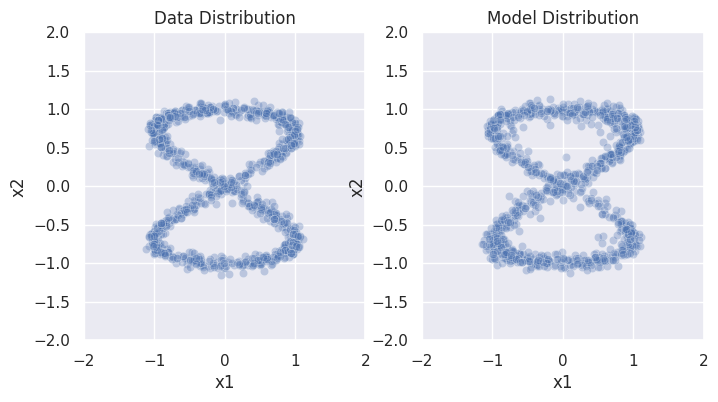

In [89]:
#@markdown Sample from the model.

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


sample_size = 1000

x_data = torch.cat([x.unsqueeze(0) for x in dataset[: sample_size]['x']], dim=0)
x_model = sample_ddpm(model, schedule, torch.randn((sample_size, 2), device=device))

sns.set()
sns.set({'figure.figsize': (8, 4)})

figure, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlim([-2, 2])
ax1.set_ylim([-2, 2])
ax1.set_title('Data Distribution')

ax2.set_xlim([-2, 2])
ax2.set_ylim([-2, 2])
ax2.set_title('Model Distribution')

plt.subplots_adjust(wspace=0.2)

sns.scatterplot(
    pd.DataFrame(x_data.cpu().numpy(), columns=['x1', 'x2']),
    x='x1',
    y='x2',
    alpha=0.3,
    ax=ax1,
)

sns.scatterplot(
    pd.DataFrame(x_model.cpu().numpy(), columns=['x1', 'x2']),
    x='x1',
    y='x2',
    alpha=0.3,
    ax=ax2,
)

plt.show()